# Kaggle G2F Competition - Classification Models

This notebook implements classification models (Logistic Regression, MLP Classifier, Gradient Boosting Classifier) to predict `Win_YN` for the Kaggle G2F competition.

In [7]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report

# For Jupyter Notebooks, plots are displayed inline
%matplotlib inline

## 1. Load Data

In [8]:
# Reading the dataset from the current working directory
script_dir = os.getcwd()
data_path = os.path.join(script_dir, 'G2F_data.csv')
print(f"Loading data from {data_path}...")
data = pd.read_csv(data_path)

Loading data from /Users/emine2/Documents/CLASSES/03_2025-FALL/TA-2025-FALL/COMPETITION/Kaggle_G2F/G2F_data.csv...


## 2. Pre-Processing

We perform the following preprocessing steps:
1. **Target Encoding**: Convert the target variable `Win_YN` from 'Y'/'N' to binary 1/0.
2. **One-Hot Encoding**: Convert categorical variables (e.g., `Hybrid`, `Env`) into numerical dummy variables using `pd.get_dummies`. We use `drop_first=True` to avoid multicollinearity.
3. **Correlation Filtering**: Remove highly correlated features (correlation > 0.9) to reduce redundancy and multicollinearity.
4. **Scaling**: Standardize features using `StandardScaler` to have a mean of 0 and a variance of 1, which is important for models like Neural Networks and Logistic Regression.

In [9]:
print("Preprocessing data...")

# Convert Target 'Win_YN' to binary (1 for Y, 0 for N)
data['Win_YN'] = data['Win_YN'].map({'Y': 1, 'N': 0})

# Handle Categorical Variables (One-Hot Encoding)
# drop_first=True to avoid multicollinearity
data_encoded = pd.get_dummies(data, drop_first=True)

# Separate Target and Features
X = data_encoded.drop('Win_YN', axis=1)
y = data_encoded['Win_YN']

# Remove Highly Correlated Features
# calculate the correlation matrix and drop features with correlation > 0.9
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(f"Dropping {len(to_drop)} highly correlated features: {to_drop}")
X = X.drop(to_drop, axis=1)

# Scale and Center Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

Preprocessing data...
Dropping 37 highly correlated features: ['pollen', 'AccPrecip_1', 'AccPrecip_2', 'AccPrecip_3', 'AccPrecip_5', 'AccPrecip_6', 'AccPrecip_7', 'AccPrecip_8', 'AccPrecip_11', 'MaxT_10', 'MaxT_11', 'MinT_1', 'MinT_8', 'MinT_10', 'MinT_11', 'ThermalTime_1', 'ThermalTime_2', 'ThermalTime_3', 'ThermalTime_5', 'ThermalTime_6', 'ThermalTime_7', 'ThermalTime_8', 'ThermalTime_10', 'ThermalTime_11', 'TempStress_1', 'TempStress_11', 'latitude', 'Env_KSH1_2016', 'field_location_COH1', 'field_location_MOH2', 'field_location_NEH1', 'field_location_NYS1', 'field_location_SDH1', 'field_location_TXH1-Dry', 'field_location_TXH1-Early', 'field_location_TXH1-Late', 'field_location_WIH3']


## 3. Splitting Dataset

In [10]:
print("Splitting data into Train (80%) and Test (20%)...")
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=100)

Splitting data into Train (80%) and Test (20%)...


## 4. Creating and Evaluating Models

Training models...

Training GLM...
GLM Accuracy: 0.8079
GLM AUC: 0.8817
GLM Confusion Matrix:
[[325  70]
 [ 57 209]]

Training NNET...
NNET Accuracy: 0.7383
NNET AUC: 0.8185
NNET Confusion Matrix:
[[300  95]
 [ 78 188]]

Training GBM...
GBM Accuracy: 0.7852
GBM AUC: 0.8795
GBM Confusion Matrix:
[[324  71]
 [ 71 195]]


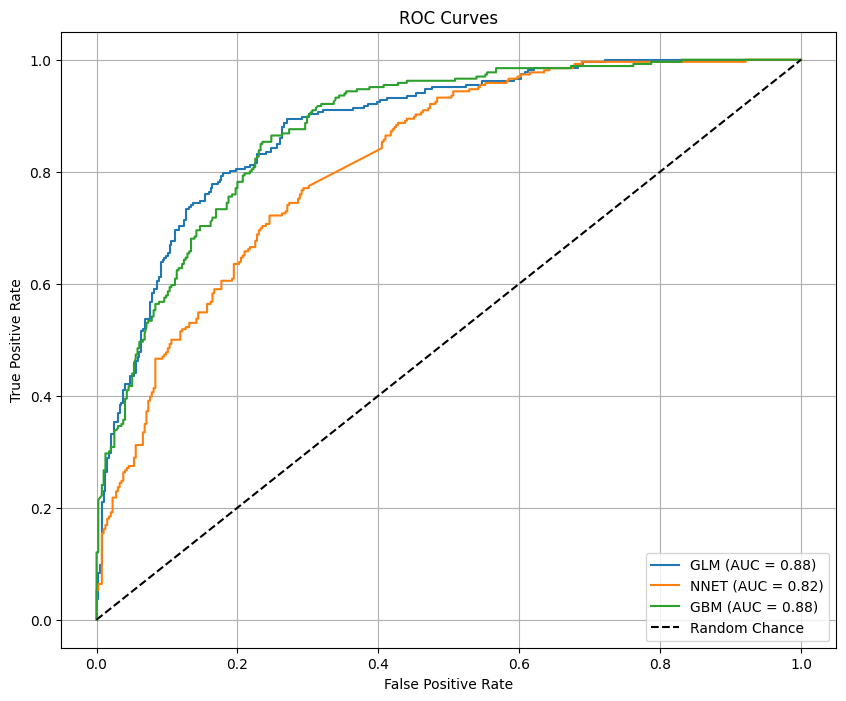

In [11]:
print("Training models...")

models = {}

# GLM -> Logistic Regression for classification
models['GLM'] = LogisticRegression(random_state=100, max_iter=1000)

# NNET -> MLPClassifier
models['NNET'] = MLPClassifier(hidden_layer_sizes=(5,), max_iter=1000, random_state=100)

# GBM -> GradientBoostingClassifier
models['GBM'] = GradientBoostingClassifier(random_state=100)

# Train and Evaluate
plt.figure(figsize=(10, 8))

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    
    # Predict classes and probabilities
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculate Metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"{name} AUC: {auc:.4f}")
    print(f"{name} Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

# Plot Settings
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()